In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
import torch

from src.FramePrediction import NextFramePredictionModel

In [2]:
X = []
Y = []

folders = [f.name for f in os.scandir("data") if f.is_dir()]
folders = [int(n) for n in folders]
folders.sort()

for folder in folders:

    print(f"Loading {folder}", end="\r")
    
    rho = np.load(f"data/{folder}/smoke.npy")
    rho = np.expand_dims(rho, -1)
    velocity = np.load(f"data/{folder}/velocity.npy")
    p = np.load(f"data/{folder}/pressure.npy")
    p = np.expand_dims(p, -1)
    
    x = np.concatenate([rho, velocity, p], axis=-1)  # Density, Velocity X, Velocity Y, Pressure
    
    y = x[3:]
    x = x[:-3]
    
    X.append(x)
    Y.append(y)

X = np.concatenate(X, axis=0)
Y = np.concatenate(Y, axis=0)

X.shape, Y.shape

((14700, 64, 64, 4), (14700, 64, 64, 4))

In [3]:
# Move channel dimension to second position
X = np.moveaxis(X, 3, 1)
Y = np.moveaxis(Y, 3, 1)

# Add time dimension (in this case it has size 1 since only one frame is used)
X = np.expand_dims(X, 1)
Y = np.expand_dims(Y, 1)

# Shape: (B, C, T, H, W)
X.shape, Y.shape

((14700, 1, 4, 64, 64), (14700, 1, 4, 64, 64))

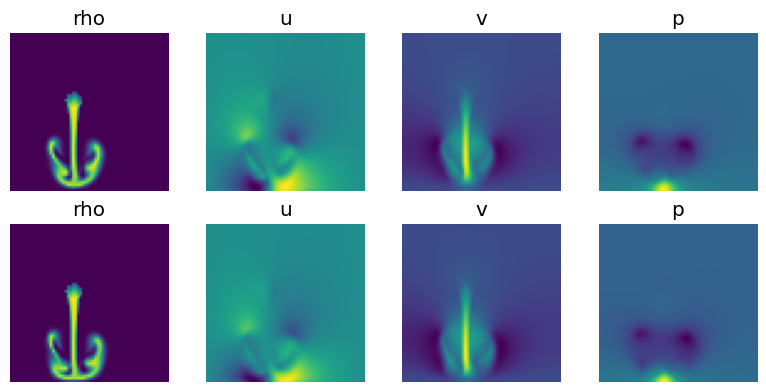

In [4]:
idx = 59

fig, axs = plt.subplots(2, 4, figsize=(8,4))

# Current frame
axs[0,0].imshow(X[idx,0,0,:,:])
axs[0,0].set_title("rho")
axs[0,0].axis("off")

axs[0,1].imshow(X[idx,0,1,:,:])
axs[0,1].set_title("u")
axs[0,1].axis("off")

axs[0,2].imshow(X[idx,0,2,:,:])
axs[0,2].set_title("v")
axs[0,2].axis("off")

axs[0,3].imshow(X[idx,0,3,:,:])
axs[0,3].set_title("p")
axs[0,3].axis("off")

# Next frame
idx_next = idx + 5
axs[1,0].imshow(Y[idx,0,0,:,:])
axs[1,0].set_title("rho")
axs[1,0].axis("off")

axs[1,1].imshow(Y[idx,0,1,:,:])
axs[1,1].set_title("u")
axs[1,1].axis("off")

axs[1,2].imshow(Y[idx,0,2,:,:])
axs[1,2].set_title("v")
axs[1,2].axis("off")

axs[1,3].imshow(Y[idx,0,3,:,:])
axs[1,3].set_title("p")
axs[1,3].axis("off")

plt.tight_layout()

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

In [6]:
EPOCHS = 50
BATCH_SIZE = 32

In [7]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF


print(torch.cuda.is_available())

for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i))

True
_CudaDeviceProperties(name='NVIDIA GeForce GTX 1650', major=7, minor=5, total_memory=4095MB, multi_processor_count=14, uuid=05ab3d70-ba04-d3db-3362-a62e271d984d, pci_bus_id=1, pci_device_id=0, pci_domain_id=0, L2_cache_size=1MB)


In [20]:
class FramesDataset(Dataset):
    """Image dataset.
    """

    def __init__(self, frames_in, frame_out):
        self.frames_in = frames_in
        self.frame_out = frame_out
        self.num_frames = self.frames_in.shape[1]

    def __len__(self):
        return len(self.frames_in)

    def __getitem__(self, index):
        x = torch.from_numpy(self.frames_in[index])
        y = torch.from_numpy(self.frame_out[index])
        return x, y
    

def train(model, train_loader, val_loader, loss_fn,
         num_epochs=10, learning_rate=1e-4,
         early_stopping={'patience': 5, 'min_delta': 0.00005}):
    
    optimizer = Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, threshold=1e-4, mode='min', patience=3, factor=0.5, min_lr=1e-6)

    loss_history = {'train_loss': [], 'val_loss': []}
    early_stop_counter = 0
    best_val_loss = float('inf')

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    print(f"Using device: {device}")
    
    total_batches = len(train_loader)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        # Training
        for i, (x, y) in enumerate(train_loader):
            
            print(f"Batch {i+1} of {total_batches}", end="\r")
            
            optimizer.zero_grad()
            
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = loss_fn(y, y_pred)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:

                x = x.to(device)
                y = y.to(device)

                y_pred = model(x)
                loss = loss_fn(y, y_pred)

                val_loss += loss.item()
                
        val_loss /= len(val_loader.dataset)
        
        scheduler.step(val_loss)

        average_loss = total_loss / len(train_loader.dataset)
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch + 1}/{num_epochs}], train_loss: {average_loss:.5f}, val_loss: {val_loss:.5f}, lr: {current_lr}')

        loss_history['train_loss'].append(average_loss)
        loss_history['val_loss'].append(val_loss)

        # Early stopping
        if epoch > 0:
            if loss_history['val_loss'][-1] < best_val_loss - early_stopping['min_delta']:
                best_val_loss = loss_history['val_loss'][-1]
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= early_stopping['patience']:
                print('Early stopping.')
                break

    print('Training finished.')

    return loss_history

In [21]:
from src.FramePrediction import NextFramePredictionModel

IN_CHANNELS = 4
HIDDEN_DIM = 32
KERNEL_SIZE = 3

BATCH_SIZE = 8
EPOCHS = 15

train_dataset = FramesDataset(X_train, Y_train)
test_dataset = FramesDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model = NextFramePredictionModel(
    in_channels=IN_CHANNELS, 
    hidden_dim=HIDDEN_DIM, 
    kernel_size=KERNEL_SIZE,
    num_convlstm_layers=3,
    num_lstmcell_layers=2,
    batch_first=True
)

total_params = sum(p.numel() for p in model.parameters())
print('Total parametes in model:', total_params)

Total parametes in model: 414532


In [22]:
loss_fn = nn.MSELoss()

loss_history = train(model, train_loader, test_loader, loss_fn, num_epochs=EPOCHS, learning_rate=0.001)

Using device: cuda
Epoch [1/15], train_loss: 0.00085, val_loss: 0.00028, lr: 0.001
Epoch [2/15], train_loss: 0.00030, val_loss: 0.00018, lr: 0.001
Epoch [3/15], train_loss: 0.00022, val_loss: 0.00012, lr: 0.001
Epoch [4/15], train_loss: 0.00019, val_loss: 0.00011, lr: 0.001
Epoch [5/15], train_loss: 0.00016, val_loss: 0.00010, lr: 0.001
Epoch [6/15], train_loss: 0.00015, val_loss: 0.00010, lr: 0.001
Epoch [7/15], train_loss: 0.00013, val_loss: 0.00010, lr: 0.001
Epoch [8/15], train_loss: 0.00012, val_loss: 0.00009, lr: 0.001
Early stopping.
Training finished.


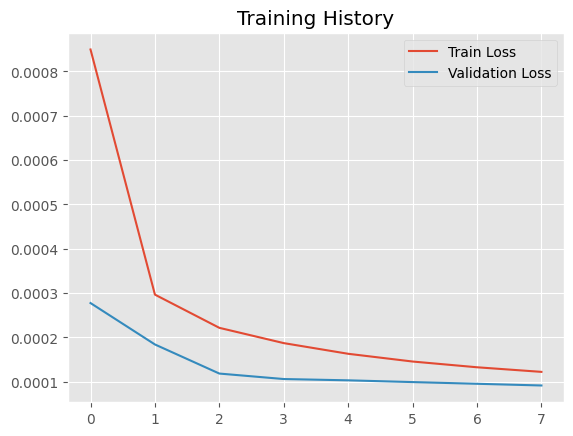

In [23]:
plt.plot(loss_history["train_loss"], label="Train Loss")
plt.plot(loss_history["val_loss"], label="Validation Loss")

plt.title("Training History")
plt.legend()

## Predict

In [24]:
idx = np.random.randint(len(test_dataset))
print(idx)

x, y_true = test_dataset[idx]

y_pred = model(x.unsqueeze(0).to('cuda'))

x = x.cpu().detach().numpy().squeeze()
y_true = y_true.cpu().detach().numpy().squeeze()
y_pred = y_pred.cpu().detach().numpy().squeeze()

x.shape, y_pred.shape, y_true.shape

1127


((4, 64, 64), (4, 64, 64), (4, 64, 64))

In [25]:
error = np.abs(y_true - y_pred)
error.max()

np.float32(0.15037024)

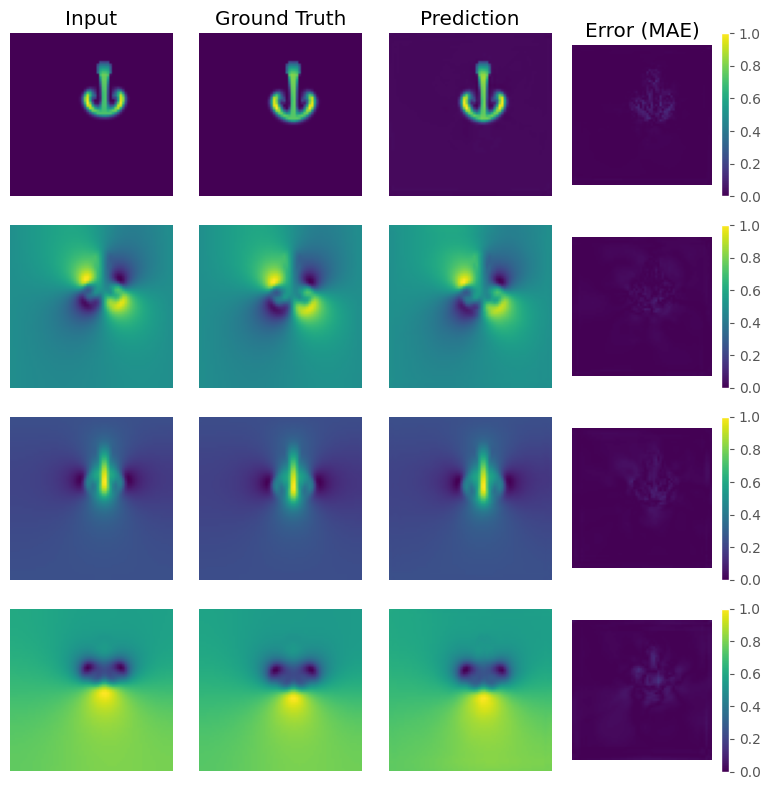

In [26]:
fig, axs = plt.subplots(4, 4, figsize=(8,8))

# Input
axs[0,0].imshow(x[0,:,:])
axs[0,0].set_title("Input")
axs[0,0].set_ylabel("rho")
axs[0,0].axis("off")

axs[1,0].imshow(x[1,:,:])
axs[1,0].set_ylabel("u")
axs[1,0].axis("off")

axs[2,0].imshow(x[2,:,:])
axs[2,0].set_ylabel("v")
axs[2,0].axis("off")

axs[3,0].imshow(x[3,:,:])
axs[3,0].set_ylabel("p")
axs[3,0].axis("off")

# Ground Truth
axs[0,1].imshow(y_true[0,:,:])
axs[0,1].set_title("Ground Truth")
axs[0,1].set_ylabel("rho")
axs[0,1].axis("off")

axs[1,1].imshow(y_true[1,:,:])
axs[1,1].set_ylabel("u")
axs[1,1].axis("off")

axs[2,1].imshow(y_true[2,:,:])
axs[2,1].set_ylabel("v")
axs[2,1].axis("off")

axs[3,1].imshow(y_true[3,:,:])
axs[3,1].set_ylabel("p")
axs[3,1].axis("off")

# Predicted
axs[0,2].imshow(y_pred[0,:,:])
axs[0,2].set_title("Prediction")
axs[0,2].set_ylabel("rho")
axs[0,2].axis("off")

axs[1,2].imshow(y_pred[1,:,:])
axs[1,2].set_ylabel("u")
axs[1,2].axis("off")

axs[2,2].imshow(y_pred[2,:,:])
axs[2,2].set_ylabel("v")
axs[2,2].axis("off")

axs[3,2].imshow(y_pred[3,:,:])
axs[3,2].set_ylabel("p")
axs[3,2].axis("off")

# Error
im = axs[0,3].imshow(error[0,:,:], vmin=0, vmax=1)
axs[0,3].set_title("Error (MAE)")
axs[0,3].set_ylabel("rho")
axs[0,3].axis("off")
plt.colorbar(im)

im = axs[1,3].imshow(error[1,:,:], vmin=0, vmax=1)
axs[1,3].set_ylabel("u")
axs[1,3].axis("off")
plt.colorbar(im)

im = axs[2,3].imshow(error[2,:,:], vmin=0, vmax=1)
axs[2,3].set_ylabel("v")
axs[2,3].axis("off")
plt.colorbar(im)

im = axs[3,3].imshow(error[3,:,:], vmin=0, vmax=1)
axs[3,3].set_ylabel("p")
axs[3,3].axis("off")
plt.colorbar(im)

plt.tight_layout()

In [27]:
idx = 0

x = torch.from_numpy(X[0]).unsqueeze(0)

frames = [x.squeeze()]

for i in range(49):
    print(i, end="\r")
    x = model(x.to('cuda'))
    frames.append(x.squeeze().cpu().detach().numpy())

frames = np.array(frames)

In [31]:
import numpy as np
from PIL import Image

def save_gif(smoke_array, velocity_array, pressure_array):
    # Scale to 0 - 255
    # NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
    smoke_array_scaled = (((smoke_array - smoke_array.min()) * 255) / (smoke_array.max() - smoke_array.min())).astype(np.uint8)
    velocity_array_scaled = (((velocity_array - velocity_array.min()) * 255) / (velocity_array.max() - velocity_array.min())).astype(np.uint8)
    pressure_array_scaled = (((pressure_array - pressure_array.min()) * 255) / (pressure_array.max() - pressure_array.min())).astype(np.uint8)

    data_dict = {"rho": smoke_array_scaled,
                "u": velocity_array_scaled[:,:,:,0],
                "v": velocity_array_scaled[:,:,:,1],
                "p": pressure_array_scaled}

    for name, img_array in data_dict.items():

        imgs = [Image.fromarray(img) for img in img_array]
        # duration is the number of milliseconds between frames; this is 40 frames per second
        imgs[0].save(f"misc/{name}.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

In [32]:
# Load true data from simulation
rho = np.load(f"data/{idx}/smoke.npy")
velocity = np.load(f"data/{idx}/velocity.npy")
p = np.load(f"data/{idx}/pressure.npy")

rho.shape, velocity.shape, p.shape

((150, 64, 64), (150, 64, 64, 2), (150, 64, 64))

In [33]:
smoke_array = frames[:,0,:,:]
velocity_array = np.moveaxis(frames[:,1:3,:,:], 1, 3)
pressure_array = frames[:,3,:,:]

# Pad pred arrays to same length
smoke_array = np.repeat(smoke_array, 3, axis=0)
velocity_array = np.repeat(velocity_array, 3, axis=0)
pressure_array = np.repeat(pressure_array, 3, axis=0)

# Prepare array for side-to-side comparison
smoke_array_big = np.zeros((smoke_array.shape[0], smoke_array.shape[1], smoke_array.shape[2]*2))
velocity_array_big = np.zeros((velocity_array.shape[0], velocity_array.shape[1], velocity_array.shape[2]*2, velocity_array.shape[3]))
pressure_array_big = np.zeros((pressure_array.shape[0], pressure_array.shape[1], pressure_array.shape[2]*2))

# Replace values
smoke_array_big[:,:,:64] = rho
smoke_array_big[:,:,64:] = smoke_array
velocity_array_big[:,:,:64,:] = velocity
velocity_array_big[:,:,64:,:] = velocity_array
pressure_array_big[:,:,:64] = p
pressure_array_big[:,:,64:] = pressure_array

# Invert y-axis
smoke_array_big = smoke_array_big[:,::-1,:]
velocity_array_big = velocity_array_big[:,::-1,:,:]
pressure_array_big = pressure_array_big[:,::-1,:]

save_gif(smoke_array_big, velocity_array_big, pressure_array_big)